# Smart Charging Using Reinforcement Learning

In [ ]:
!pip install -q keras-rl2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import math
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

## Electric Vehicle Charging Environment
We start by creating the environment for simulating electric vehicle (EV) charging using the OpenAI Gym framework. The environment defines a Markov decision process, including states, actions and a reward function with different charging rates and time-dependent energy prices.

### Key Components

- `action_space`: The environment offers four charging actions: no charge, low, medium, and high charging.

- `battery_limit`: Represents the EV's battery capacity, assumed to be 58 kWh.

- `battery_level`: Initialized to the battery's full capacity at the start.

- `observation_space`: A state consists of the battery level and the current time interval.

- `current_time_index`: Tracks the time interval (0-8) for charging intervals. (0: 14.00; 1: 14.15; 2: 14.30; 3: 14.45; 4: 15.00; 5: 15.15; 6: 15.30; 7: 15.45; 8: 16.00)

- `time_coefficients`: Coefficients representing volatile energy prices from 2pm to 4pm ranging from 43.40$/MWh to 48.49$/MWh (More on that below)

- `charging_rates`: Charging rates for different actions (0, 1.75, 3.5, 5.5 kWh).

### Functions

- `step(action)`: Simulates one time step in the environment. The agent's action determines the charging rate, and the environment updates the battery level, calculates rewards based on energy prices, and applies penalties for insufficient battery levels.

- `reset()`: Resets the environment to the initial state, including battery level and time.

### Objective

The agent's objective is to make charging decisions that minimize costs, considering time of day and charging rate. By interacting with this environment, the agent can learn strategies to optimize the charging process and manage the EV's battery effectively.

#### Calculate time coefficients
We understand the time coefficient as factor representing the volatility in energy prices. Therefore, we create a list of 8 time coefficients, each representing the proportion of the highest price in the given period. We observed the baseline prices from the platform https://www.iea.org/data-and-statistics/data-tools/real-time-electricity-tracker. The application yielded the following results for the period from 15/07/2023 to 14/08/2023 (only weekdays):
- 2pm: 43.40 $/MWh
- 3pm: 45.03 $/MWh
- 4pm: 48.49 $/MWh

In [ ]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(NUM_ACTIONS)
        self.battery_limit = BATTERY_LIMIT
        self.battery_level = self.battery_limit
        self.energy_demand = 0

        # A state in the environment consists of battery level and time interval
        self.observation_space = np.array([Box(low=np.array([0]), high=np.array([self.battery_limit])), Box(low=np.array([0]), high = np.array([8]))])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index])

        # Set time coefficient following energy price increase in US
        self.time_coefficients = [0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0, 1.75, 3.5, 5.5]
        # scale charging rates to avoid numerical instability
        self.charging_rates_scaled = [0, 0.25, 0.5, 1]

    def step(self, action):

        charging_rate = self.charging_rates[action]
        charging_rate_scaled = self.charging_rates_scaled[action]

        if self.battery_level + charging_rate > self.battery_limit:
            self.battery_level = self.battery_limit
        else:
            self.battery_level += charging_rate

        reward = self.time_coefficients[self.current_time_index] * math.exp(charging_rate_scaled) * (-1)
        reward = round(reward, 2)

        if charging_rate == 0:
            reward = 0

        self.current_time_index += 1

        # Update time index
        self.state[0] = int(self.battery_level)
        self.state[1] = self.current_time_index

        # Check if simulation is complete
        done = self.current_time_index == 8

        if done:
            # Get energy demand from normal distribution
            self.energy_demand = np.random.normal(30, 5)

            if self.battery_level < self.energy_demand:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 1000

        return self.state, reward, done, {}

    def reset(self):

        self.battery_level = max(0, self.battery_level - self.energy_demand)

        self.current_time_index = 0
        self.state = np.array([int(self.battery_level), self.current_time_index])
        return self.state

#### Further exploring of the envrionment by checking environment functionality

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

episodes = 2

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
        print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")

    print(f"Episode {episode} - Score: {round(score,2)}\n{'*' * 50}")


Episode 1
Initial State: [58  0]
Action: 0 | New State: [58  1] | Reward: 0 | Done: False
Action: 3 | New State: [58  2] | Reward: -2.47 | Done: False
Action: 0 | New State: [58  3] | Reward: 0 | Done: False
Action: 1 | New State: [58  4] | Reward: -1.21 | Done: False
Action: 2 | New State: [58  5] | Reward: -1.58 | Done: False
Action: 2 | New State: [58  6] | Reward: -1.6 | Done: False
Action: 2 | New State: [58  7] | Reward: -1.63 | Done: False
Action: 1 | New State: [58  8] | Reward: -1.28 | Done: True
Episode 1 - Score: -9.77
**************************************************
Episode 2
Initial State: [29  0]
Action: 2 | New State: [32  1] | Reward: -1.48 | Done: False
Action: 3 | New State: [38  2] | Reward: -2.47 | Done: False
Action: 1 | New State: [40  3] | Reward: -1.19 | Done: False
Action: 1 | New State: [41  4] | Reward: -1.21 | Done: False
Action: 1 | New State: [43  5] | Reward: -1.23 | Done: False
Action: 1 | New State: [45  6] | Reward: -1.25 | Done: False
Action: 0 | Ne

- Episode 1: We start with full battery level and take the first 8 charging actions, We can see that the agent receives negative rewards for trying to charge, although the battery is fully charged. Therefore, we penalize the agent slightly for not choosing the zero decision when the battery is full.
- Episode 2: We can see that the first state holds a new battery level: 29. It represents the battery level of the last episode subtracted by the energy demand following the given normal distribution. In the following time steps we see that the agent takes charging decision and receives a higher battery level as new state.

## Deep Q-Network

In the next step we create a deep Q-Network for approximating the Q-values in our environment. With Q-Learning we are able to learn about the greedy policy, while using a different behaviour policy for acting in the environment. The behaviour policy is usually an $\epsilon$-greedy policy, that selects the greedy action with probability 1 - $\epsilon$ and a random action with probability $\epsilon$ to ensure good coverage of the state-action space. We decided to learn three different agents, differing in their behavior policy for learning: We implemented BoltzmannQPolicy and two EpsilonGreedyPolicies, one with ε = 0 and one with ε = 0.1. Each of the three agents was trained over 50,000 steps or 6,250 episodes.

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

states = env.observation_space.shape
actions = env.action_space.n

model = build_model(states, actions)
memory = SequentialMemory(limit=50000, window_length=1)


# DQN Boltzmann
bo_policy = BoltzmannQPolicy()
dqn_boltzmann = DQNAgent(model=model, memory=memory, policy=bo_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_boltzmann.compile(Adam(lr=1e-3), metrics=['mae'])


# DQN e-greedy 0
e_0_policy = EpsGreedyQPolicy(eps=0)
dqn_e_0 = DQNAgent(model=model, memory=memory, policy=e_0_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_e_0.compile(Adam(lr=1e-3), metrics=['mae'])


# DQN e-greedy 0.1
e_01_policy = EpsGreedyQPolicy(eps=0.1)
dqn_e_01 = DQNAgent(model=model, memory=memory, policy=e_01_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_e_01.compile(Adam(lr=1e-3), metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training first agent with BoltzmannQPolicy

In [ ]:
training_results_bo = dqn_boltzmann.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 112s 11ms/step - reward: -3.2660
1250 episodes - episode_reward: -26.128 [-1013.380, -6.640] - loss: 863.186 - mae: 47.743 - mean_q: -14.807

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -2.2911
1250 episodes - episode_reward: -18.329 [-20.670, -10.610] - loss: 72.003 - mae: 25.015 - mean_q: -11.980

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -1.9282
1250 episodes - episode_reward: -15.426 [-1015.750, -7.660] - loss: 39.804 - mae: 9.437 - mean_q: -6.401

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 104s 10ms/step - reward: -1.8165
1250 episodes - episode_reward: -14.532 [-20.670, -8.860] - loss: 43.784 - mae: 8.303 - mean_q: -5.565

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -2.1081
done, took 528.661 seconds


In [ ]:
results = dqn_boltzmann.test(env, nb_episodes=150, visualize=False, verbose=0)
print(np.mean(results.history['episode_reward']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-13.638799999999998


DQN_Boltzmann returns an average reward of -13.64 over 1,000 test episodes.

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_boltzmann.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward

    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

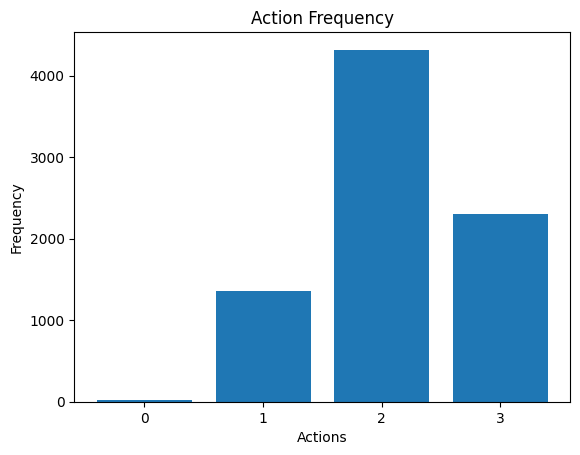

In [ ]:

flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

DQN_Boltzmann Agent has a high frequency of medium charging, followed by high charging. It nearly never chooses to charge zero. We assume that this behavior results the agent trying to strictly avoid running out of energy.

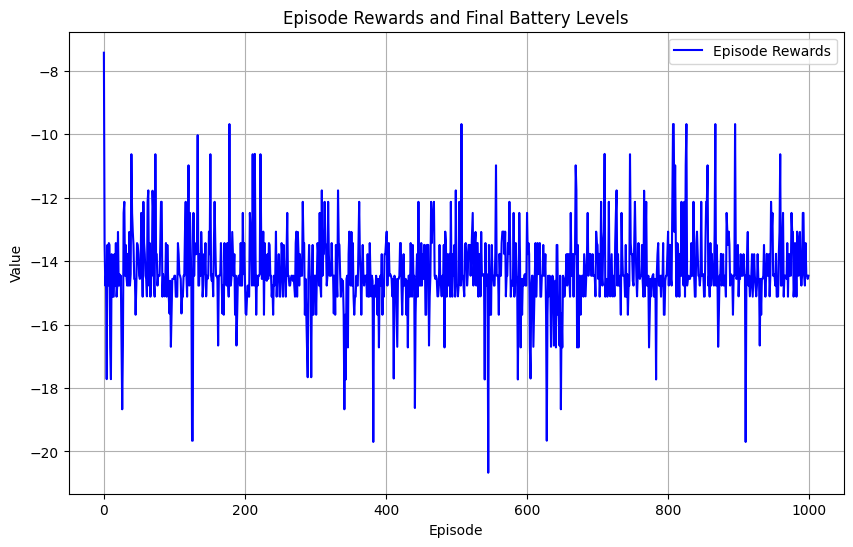

In [ ]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

We can see that the Boltzmann DQN never receives a penalty over 1,000 episodes. The charging costs (scaled) are mostly in the range between -12 and -16.

### Training second agent with Epsilon Greedy Policy with epsilon = 0


In [ ]:
training_results_e_0 = dqn_e_0.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -2.3759
1250 episodes - episode_reward: -19.007 [-1015.570, -5.410] - loss: 107.397 - mae: 6.815 - mean_q: -4.990

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.8075
1250 episodes - episode_reward: -14.460 [-20.670, -7.670] - loss: 132.545 - mae: 9.129 - mean_q: -6.734

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.9028
1250 episodes - episode_reward: -15.223 [-1013.490, -8.010] - loss: 115.522 - mae: 9.387 - mean_q: -7.043

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.9030
1250 episodes - episode_reward: -15.224 [-1012.520, -5.920] - loss: 122.624 - mae: 8.729 - mean_q: -7.243

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 106s 11m

In [ ]:
results = dqn_e_0.test(env, nb_episodes=150, visualize=False, verbose=0)
print(np.mean(results.history['episode_reward']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-20.340733333333333


DQN_e_0 returns an average reward of -20.34 over 1,000 test episodes. That is worse than dqn_boltzmann. Choosing always the greedy action might lead to missing potentials for cost savings and propagating them to the q-network.

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_e_0.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward

    #print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")


    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


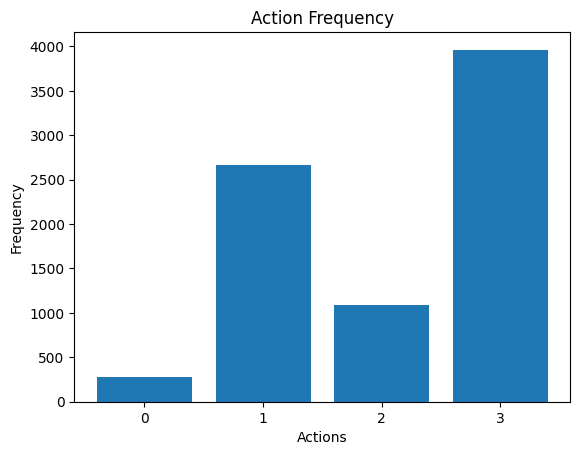

In [ ]:
flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

The greedy policy of dqn_e_0 results in preferring high charging. The choice of low charging is more frequent here. We assume that this is because of the low cost of action 1, while the risk of penalty is not that high for this action as it is for action 0.

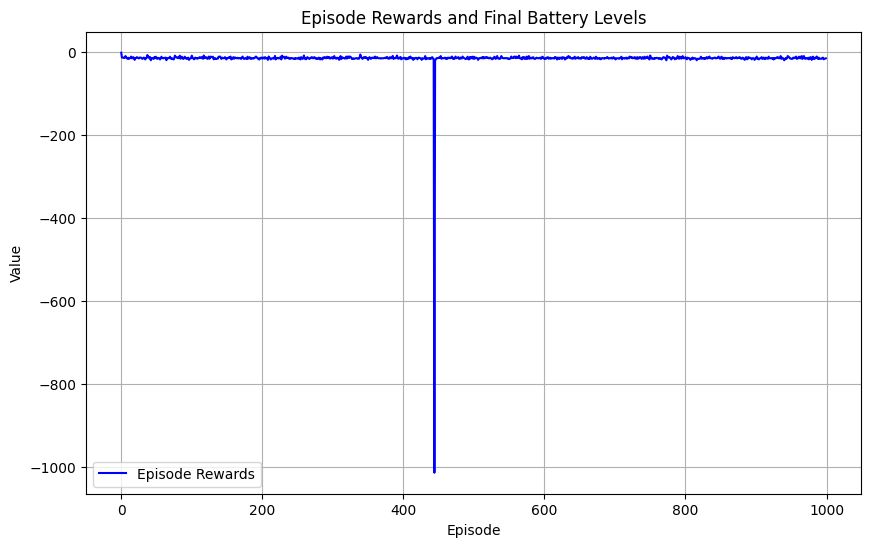

In [ ]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Here we can see, that dqn_e_0 receives the penalty for running out of energy after around 400 episodes. That might come from preferring the low charging option, which inherits the risk of charging too low for fulfilling the energy demand in the end.

### Training third agent with Epsilon Greedy Policy with epsilon = 0.1

In [ ]:
training_results_e_01 = dqn_e_01.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -3.7624
1250 episodes - episode_reward: -30.099 [-1017.610, -7.670] - loss: 183.046 - mae: 7.068 - mean_q: -6.284

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -2.1037
1250 episodes - episode_reward: -16.830 [-1015.900, -6.460] - loss: 231.330 - mae: 8.355 - mean_q: -7.824

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.7945
1250 episodes - episode_reward: -14.356 [-20.670, -5.250] - loss: 233.636 - mae: 8.220 - mean_q: -7.351

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.7819
1250 episodes - episode_reward: -14.255 [-20.670, -5.110] - loss: 189.144 - mae: 7.888 - mean_q: -6.927

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 107s 11ms/

In [ ]:
results = dqn_e_01.test(env, nb_episodes=150, visualize=False, verbose=0)
print(np.mean(results.history['episode_reward']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-13.611666666666665


Dqn_e_0_1 holds the best mean average reward with -13.62. It is nearly the same than the avg. reward by the BoltzmannQPolicy Agent.

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_e_01.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward

    #print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")


    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


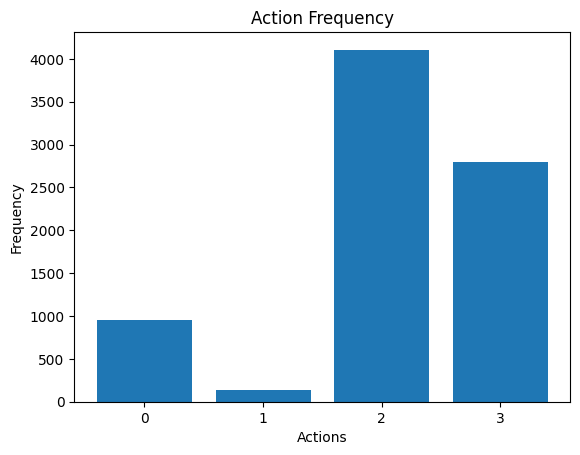

In [ ]:
flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

Like dqn_boltzmann, the dqn_e_01 prefers actions 3 and 2. But here action 2 is more frequent. Through greedy actions the agent might have learnt, that charging with 2 has lower costs than option 3, while fulfilling energy demand in the most cases anyway.

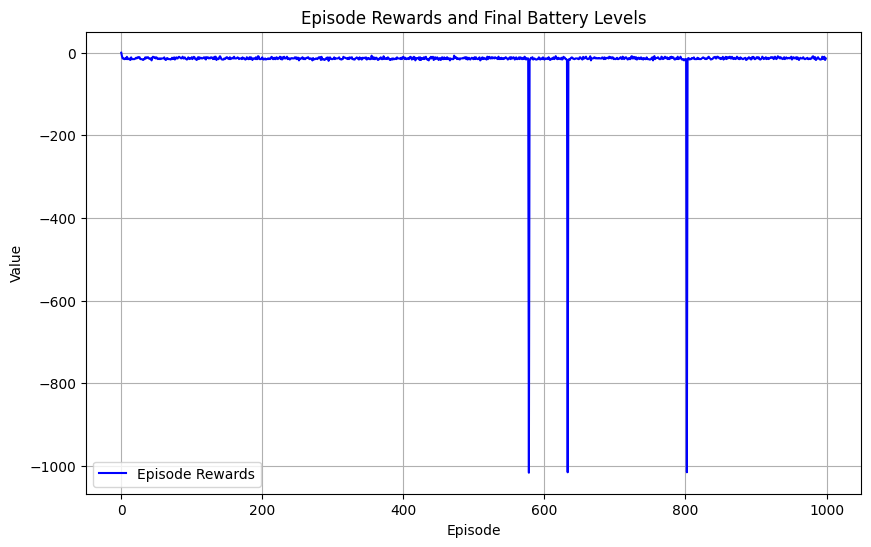

In [ ]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Here we can see the tradeoff of the slightly better average reward of dqn_e_0_1: Relying more on option 2 for lower immediate charging costs increases the risk of not fulfilling energy demand. Here we have three episodes, where the demand was not fulfilled. Even if the learnt policy might seem to maximize the rewards, its use is harmful due to risk of running out of energy.

**Results**

We observe, that the Boltzmann-Agent nearly never takes the zero action, whereas the epsilon-greedy agent with epsilon = 0.1 charges zero more often. This behavior results probably from the higher explo- ration rate in epsilon-greedy behavior. We can see also, that all agents rely heavily on charging full or medium. In general, this behavior is logical: For fulfilling the demand of about 30 kW each episode, we need to charge heavily for a maximum charging rate of 44 kW over 2 hours and a high penalty of charging too less. Only the agent trained with BoltzmannQPolicy was able to avoid receiving the -1,000 penalty score for running out of energy. The high negative peaks in the last and second to last rewards plot show, that the agents learned with Epsilon Greedy Policy were not able to avoid running out of energy completely over 1,000 episodes.

In conclusion, the agent learned with BoltzmannQPolicy fits best for our scenario. The average reward is nearly same high than the one by EpsGreedy (Eps=0.1), whereas its policy is not that risk taking than EpsGreedy. Never running out of energy over 1,000 episodes shows that the BoltzmannQPolicy agent is appropriate for use as an charging decision maker in our environment.